# Field Mapping Code: Thresholding Approach Demonstration Notebook

This notebook walks through the different processing steps of processing imagery into field boundaries via the Thresholding approach. The Thresholding approach passes a set of threshold values to several layers that are useful for differentiating crop pixels from non-crop pixels: NDVI max, NDVI range, NDWI, and Edge magnitude. This creates a binary crop mask, which is then applied to an RGB image that gets passed to a segmentation algorithm to create field polygon objects.

The core functions are stored in the fields_functions.py file, which references a file with global parameters, the global_config.py file, that stores parameters in a dictionary. Refer to that file to see what each parameter controls. Changing parameters can be done interactively in this notebook by reassigning new values to the parameter, such as: `config['prep_file_dir'] = 'path/to/directory/with/sentinel/tiles/'`. Refer to the functions in the fields_functions.py to edit the processing workflow.

### Import packages

First, check the contents of the current working directory to make sure the python files with the functions and global parameters are accessible. Then, load import the fields_functions.py file. The config parameters are stored in the global_config.py, imported at the top of the fields_functions.py along with all the packages necessary for processing. 

In [1]:
import os
from glob import glob
from pprint import pprint

cwd = os.getcwd()
print(cwd)

py_files = glob('*.py')
print(py_files)

C:\Users\jesse\Documents\grad school\masters research\code\EveryField
['fields_functions.py', 'global_config.py']


In [2]:
### Import fields functions
from fields_functions import *

### Defining parameters

First, we have to load the parameters into variables from the global config because the config dictionary is not directly incorporated into the thresholding functions.

In [16]:
%%time
## Example code for running Thresholding approach
## These functions are not integrated into the global config, so variables have to be defined before the function call

### Set file paths for read and write
file_out_str = '_code_demo_threshold'
out_dir = config['shp_out_dir']
tile_id = config['prep_tile_id']
raster_dir = config['prep_file_dir']
x_start = config['prep_x_start']
y_start = config['prep_y_start']
step = config['prep_step']
base_chunk = 'auto'

## Data read parameters
cloud_thresh = 20

## Crop maask parameters
ndwi_thresh = 0.5 
ndvi_max_thresh = 0.5
ndvi_range_thresh = 0.5 
edges_thresh = 0.3

# set rgb date string from the dict
rgb_date_str = rgb_date_dict[tile_id]
rgb_gaussian_sigma = config['seg_rgb_gaussian_sigma']
fz_scale = config['seg_fz_scale']
fz_sigma = config['seg_fz_sigma']
fz_min_size = config['seg_fz_min_size']

Wall time: 0 ns


### Loading data for thresholding approach

For this approach, we will use a set of sample data that was prepared without using a cloud mask. To avoid contamination from cloud coverage, we use a more restrictuve cloud threshold value so that only snapshots with less than 20% cloud coverage are read into our dataset. We will give this data the `ds_time_stack` object name.

In order to utilize parallel processing with dask within xarray, make sure to set a chunk size when reading in the data. You can use the keywork 'auto' to have dask automatically set a chunk size based on data size and memory limitations

In [20]:
### Loading sample data directly from netCDF file

# filepath to the sample data
# sample_data_fp = 'C:/Users/jesse/Documents/grad school/masters research/code/fields_library/thesis_code_cleanup/sample_data/sample_data_TPT_px500_cldcov40_cldmask.nc'
sample_data_fp = 'sample_data/sample_data_TPT_px500_cldcov20_Nocldmask.nc'


### In order to utilize parallel processing with dask within xarray, make sure to set a chunk size when reading in the data.
### You can use the keywork 'auto' to have dask automatically set a chunk size based on data size and memory limitations
ds_time_stack = xr.open_dataset(sample_data_fp, chunks={'x':'auto', 'y':'auto','time':'auto'})
print(ds_time_stack)

<xarray.Dataset>
Dimensions:  (time: 18, x: 500, y: 500)
Coordinates:
  * x        (x) float64 6.75e+05 6.75e+05 6.75e+05 ... 6.8e+05 6.8e+05 6.8e+05
  * y        (y) float64 5.208e+06 5.208e+06 5.208e+06 ... 5.203e+06 5.203e+06
  * time     (time) datetime64[ns] 2019-05-31 2019-06-05 ... 2019-10-28
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
Attributes:
    transform:     [ 1.00000e+01  0.00000e+00  6.00000e+05  0.00000e+00 -1.00...
    crs:           +init=epsg:32614
    res:           [10. 10.]
    is_tiled:      1
    nodatavals:    [nan nan nan nan]
    scales:        [1. 1. 1. 1.]
    offsets:       [0. 0. 0. 0.]
    descriptions:  ['B4, central wavelength 665 n

### Visualize a band from the sample data
Since the data is stored in an xarray dataset, we can use the built in wrapper for matplotlib to visualize the raster imagery. We do this by selecting a single date from the time stack using an index selection method along the time dimension `.isel(time=9)` to extract the DataArray for that time step, and then call the band that we want to visualize directly using `.nir`. We can use this syntax to select any of the data variables (in our case, spectral bands) to visualize. Alternately, we can select the band with syntax similar to pandas such as: `ds_time_stack.isel(time=9)['nir']`. Then we use the `.plot()` method to display the selected band.

Wall time: 160 ms


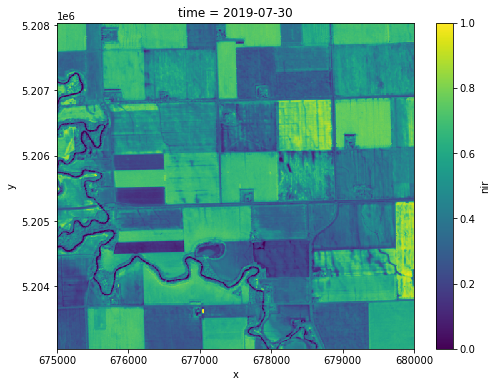

In [21]:
%%time

ds_time_stack.isel(time=9).nir.plot(figsize=(8,6))

# ds_time_stack.isel(time=9)['nir'].plot(figsize=(8,6)) ### Equivalent operation

### Breaking down the thresholding approach by step

In the cells below, each step of the thresholding approach is broken out. First we create a crop mask by passing a series of threshold values to the NDVI mean monthly max, NDVI mean monthly change from May to peak, mean edge magnitude, and NDWI. Then, we prepare a cloud free RGB image to use for segmentation and apply the mask to it. Then we pass the masked RGB image to the segmentation step to create the field polygons. Finally, we write the field polygons to a shapefile.

For each step, the output is added to the ds_time_stack data structure as a new data variable. This keeps all the data organized and with consistent spatial metadata throughout the process. Printing the ds_time_stack dataset after each step reveals the intermediate outputs: mask, rgb, fz_segments (segmented field polygons).

#### Mask processing: Water masking with NDWI
The first step is to create the crop mask using a series of thresholds on a set of derived imagery layers: Monthly Mean NDVI, NDWI, and Edges.

The first step is to compute the average NDWI for the full growing season and apply a threshold value

Wall time: 918 ms


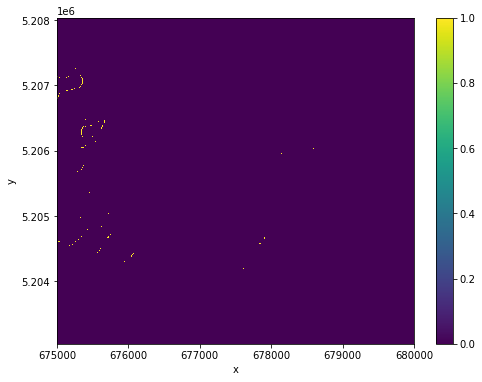

In [25]:
%%time

### NDWI mask: mean NDWI across all time steps, masked for values greater than ndwi_thresh
ndwi_mask = ndwi_mask_func(ds_time_stack, ndwi_thresh = ndwi_thresh)

ndwi_mask.plot(figsize=(8,6))

#### Vegetation masking with NDVI

Then we look at NDVI, computing a monthly mean NDVI value then thresholding the maximum values and the range between the first month NDVI and the maximum NDVI, to identify pixels that show a large growth in vegetation over the growing season.

Wall time: 848 ms


C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


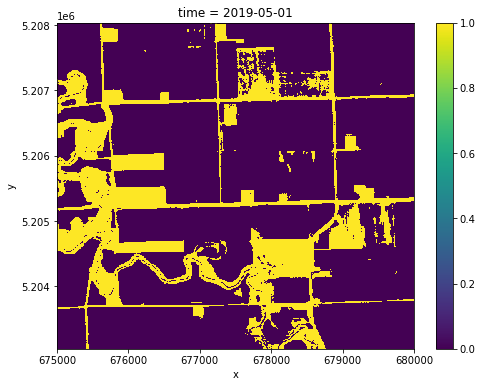

In [23]:
%%time

### NDVI Masking
# Compute mean NDVI on the monthly composite images as input to the NDVI masking function
# Compute NDVI mask: Max monthly mean NDVI > max_thresh, and Max Monthly NDVI - May monthly mean NDVI 
combined_ndvi_mask = mask_ndvi_max_and_range(ndvi_xr_norm(ds_time_stack.resample(time='1MS').mean(skipna = True)), 
                                             max_thresh = ndvi_max_thresh, 
                                             range_thresh = ndvi_range_thresh)

combined_ndvi_mask.plot(figsize=(8,6))

#### Edge detection with the sobel edge filter

Then we look at the persisten edges in the imagery to mask out the boundaries between neighboring fields that might have similar vegetative characteristics in the other components of the mask. We pass the sobel edge algorithm over each band in each time step and take the average edge magnitude for the full season. Then we pass a threshold value to that layer to create a mask.

Wall time: 0 ns


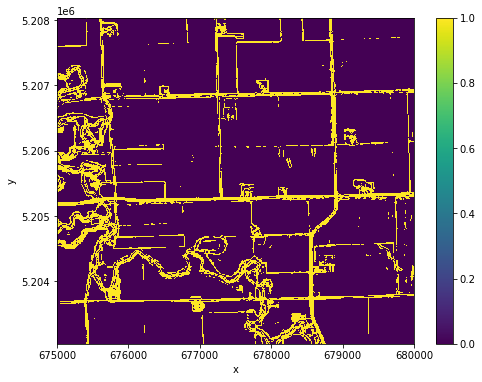

In [24]:
%time

### Edges
# Mean edges for full data stack
edges_mean = compute_edges(ds_time_stack)
# Mask edges
edges_mask = xr.where(edges_mean > edges_thresh, 1, 0)

edges_mask.plot(figsize=(8,6))

#### Combining all the masks into a binary crop mask

In [26]:
### Combined mask is a combination of the component masks via a logical OR function
### If a pixel is masked out in any of the component masks it is masked out in the combined mask layer
combined_mask = xr.ufuncs.logical_or(xr.ufuncs.logical_or(ndwi_mask, combined_ndvi_mask), edges_mask)
# Invert mask
combined_mask = xr.where(combined_mask == 1, 0, 1)

### Fill holes in the mask so that there aren't stray pixels
combined_mask = combined_mask.data.map_overlap(fill_holes, depth=1)

### Set minimum filter to enforce minimum height/width of background. 
### This eliminates small isolated areas and expands road areas.
### This can be replaced with some of the morphological filters used in the cluster mask clean up process
combined_mask = combined_mask.map_overlap(min_filter, depth = 1)

### Set mask to ds_time_stack array
ds_time_stack['mask'] = xr.DataArray(combined_mask, 
                                 dims=('y','x'),
                                 coords = [ds_time_stack['red'].coords['y'],
                                           ds_time_stack['red'].coords['x']])

print(ds_time_stack)

<xarray.Dataset>
Dimensions:  (time: 18, x: 500, y: 500)
Coordinates:
  * x        (x) float64 6.75e+05 6.75e+05 6.75e+05 ... 6.8e+05 6.8e+05 6.8e+05
  * y        (y) float64 5.208e+06 5.208e+06 5.208e+06 ... 5.203e+06 5.203e+06
  * time     (time) datetime64[ns] 2019-05-31 2019-06-05 ... 2019-10-28
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    mask     (y, x) bool dask.array<chunksize=(500, 500), meta=np.ndarray>
Attributes:
    transform:     [ 1.00000e+01  0.00000e+00  6.00000e+05  0.00000e+00 -1.00...
    crs:           +init=epsg:32614
    res:           [10. 10.]
    is_tiled:      1
    nodatavals:    [nan nan nan nan]
    scales:        [1. 1. 1. 1.]
    off

C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


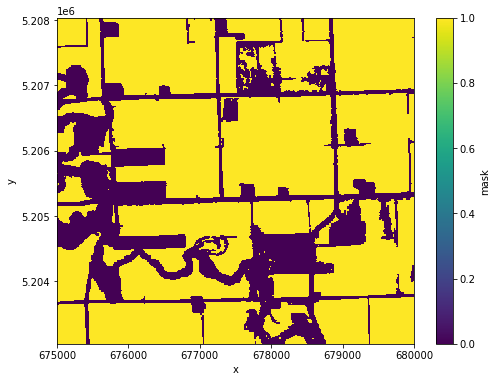

In [27]:
ds_time_stack.mask.plot(figsize=(8,6))

We can also combine the entire masking process into a single function, as it is below. Since we already have the mask as part of the `ds_time_stack` object as a data variable, essentially as a new imagery band, we can skip the cell below

In [ ]:
%%time

# ### Create crop mask in a single function
# ds_time_stack = mask_processing(ds_time_stack, 
#                                 ndwi_thresh = ndwi_thresh, 
#                                 ndvi_max_thresh = ndvi_max_thresh, 
#                                 ndvi_range_thresh = ndvi_range_thresh, 
#                                 edges_thresh = edges_thresh)

# print(ds_time_stack)

# ### plot crop mask
# ds_time_stack.mask.plot(figsize=(8,6))

### Preparing an image for segmentation

Now that we have the crop mask, we need to apply it to an image that we can pass to the segmentation algorithm that will produce field polygons. The segmentaiton algorithm expects a three-channel RGB image and will segment it based on similarity of color and spatial proximity. To prep an image, we select a time step without clouds during peak growing season (this was a manual process, but can be automated) and apply the crop mask. This masked RGB raster gets added to the `ds_time_stack` as another data variable.

In [32]:
%%time

ds_time_stack['rgb'] = rgb_image(rgb_date_str = rgb_date_str, 
                                          ds_time_stack = ds_time_stack, 
                                          rgb_chunk_size = {'band': "auto", 'x': base_chunk, 'y': base_chunk}, 
                                          gaussian_filt = True, 
                                          gaussian_sigma = rgb_gaussian_sigma, 
                                          percentile = 1)
print(ds_time_stack)

<xarray.Dataset>
Dimensions:  (band: 3, time: 18, x: 500, y: 500)
Coordinates:
  * x        (x) float64 6.75e+05 6.75e+05 6.75e+05 ... 6.8e+05 6.8e+05 6.8e+05
  * y        (y) float64 5.208e+06 5.208e+06 5.208e+06 ... 5.203e+06 5.203e+06
  * time     (time) datetime64[ns] 2019-05-31 2019-06-05 ... 2019-10-28
  * band     (band) <U1 'r' 'g' 'b'
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    mask     (y, x) bool dask.array<chunksize=(500, 500), meta=np.ndarray>
    rgb      (y, x, band) float64 dask.array<chunksize=(500, 500, 3), meta=np.ndarray>
Attributes:
    transform:     [ 1.00000e+01  0.00000e+00  6.00000e+05  0.00000e+00 -1.00...
    crs:           +init=epsg:3

C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Wall time: 2.78 s


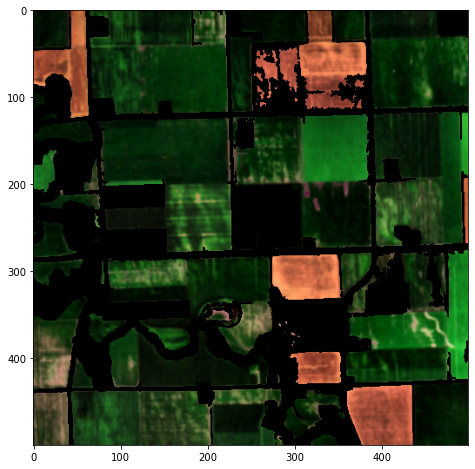

In [34]:
%%time

### plot masked RGB image
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(exposure.equalize_adapthist(ds_time_stack.rgb))

### Segmenting the imagery into field polygons

Next, we use the masked RGB image as input to the segmentation algorithm. Since the data is stored as a dask array within the xarray dataset, we can utilize the `dask.map_blocks()` function to map the segmentation algorithm (in this case, the felzenszwalb algorithm from the skimage library) across the chunks of the RGB image with an overlap to account for the seams between chunks. By calling the rgb data variable with `.data` we can access the array as a dask array, which allows us to use parallel processing functions from dask within an xarray data structure.

In [35]:
%%time 
### Segment the RGB image
fz_segments = ds_time_stack.rgb.data.map_blocks(segment_fz, scale = fz_scale, sigma = fz_sigma, min_size = fz_min_size, drop_axis = 2)
ds_time_stack['fz_segments'] = xr.DataArray(fz_segments.astype('int32'), 
                                            dims=('y','x'),
                                            coords = [ds_time_stack['red'].coords['y'],ds_time_stack['red'].coords['x']])
print(ds_time_stack)

<xarray.Dataset>
Dimensions:      (band: 3, time: 18, x: 500, y: 500)
Coordinates:
  * x            (x) float64 6.75e+05 6.75e+05 6.75e+05 ... 6.8e+05 6.8e+05
  * y            (y) float64 5.208e+06 5.208e+06 ... 5.203e+06 5.203e+06
  * time         (time) datetime64[ns] 2019-05-31 2019-06-05 ... 2019-10-28
  * band         (band) <U1 'r' 'g' 'b'
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(18, 500, 500), meta=np.ndarray>
    mask         (y, x) bool dask.array<chunksize=(500, 500), meta=np.ndarray>
    rgb          (y, x, band) float64 dask.array<chunksize=(500, 500, 3), meta=np.ndarray>
    fz_segments  (y, x) int32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Attributes:
    tr

C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Wall time: 3.33 s


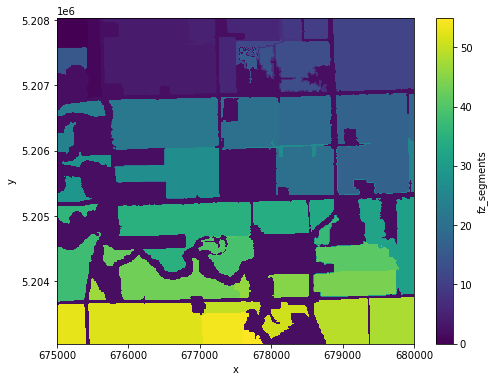

In [36]:
%%time

### Plot field segments
ds_time_stack.fz_segments.plot(figsize=(8,6))

### Saving to shapefile

Finally, we can export the segmented field objects to a shapefile by utilizing the spatial metadata in the `ds_time_stack` from when we loaded the initial raster imagery. This makes the xarray data structure particularly useful for handling spatial data.

In [22]:
%%time

## write to shapefile
config['shp_file_out_str'] = file_out_str

write_shapefile(ds_time_stack.fz_segments.values, ds_time_stack, ds_time_stack.mask)


C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


-------Writing to Shapefile-------


C:\Users\jesse\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Output saved to: shp_dir/TPT_code_demo_threshold_x7500_y7500_step500.shp
Wall time: 11.4 s
